In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score
import random
from scipy.stats import kendalltau

In [48]:
df = pd.read_csv('contest_results_elo.csv', parse_dates=['contest_date'])

In [49]:
df.head()

,Unnamed: 0,organization,contest_name,contest_date,division,class,competitor_name,placing,elo_rating,elo_rank
0,17038,ifbb,ifbb flex pro,2012-02-18,fitness,open,adela garcia,1.0,1500.0,1.0
1,17030,ifbb,ifbb flex pro,2012-02-18,fitness,open,allison ethier,9.0,1500.0,2.0
2,17034,ifbb,ifbb flex pro,2012-02-18,fitness,open,bethany wagner,5.0,1500.0,3.0
3,17031,ifbb,ifbb flex pro,2012-02-18,fitness,open,camala rodriguez,8.0,1500.0,4.0
4,17033,ifbb,ifbb flex pro,2012-02-18,fitness,open,jodi boam,6.0,1500.0,5.0


# Evaluating Ranking Metrics

In [50]:
rows_list = []
for org in df['organization'].unique():
    df_org = df[df['organization'] == org]
    for div in df_org["division"].unique():
        df_div = df_org[df_org['division'] == div]
        print(div)
        for clss in df_div["class"].unique():
            df_clss = df_div[df_div['class'] == clss]
            for dt in df["contest_date"].unique():
                df_dt = df_clss[df_clss["contest_date"] == dt]
                ndcg_scores = []
                ndcg_scores_random = []
                kt_corr = []
                kt_pvalues = []
                kt_corr_random = []
                kt_pvalues_random = []
                prec_5_scores = []
                prec_5_scores_random = []
                for ctst in df_dt["contest_name"].unique():
                    temp_df = df_dt[df_dt["contest_name"] == ctst]
                    temp_df = temp_df.dropna()
                    if len(temp_df) < 2:
                        continue
                    y_true = temp_df["placing"]
                    y_predict = temp_df["elo_rank"]
                    ndcg_scores.append(ndcg_score([y_true], [y_predict], ignore_ties=True))
                    kt_corr.append(kendalltau(y_true, y_predict).statistic)
                    kt_pvalues.append(kendalltau(y_true, y_predict).pvalue)
                    y_predict = list(y_predict)
                    random.shuffle(y_predict)
                    ndcg_scores_random.append(
                        ndcg_score([y_true], [y_predict], ignore_ties=True)
                    )
                    kt_corr_random.append(kendalltau(y_true, y_predict).statistic)
                    kt_pvalues_random.append(kendalltau(y_true, y_predict).pvalue)
                    if len(temp_df) > 5:
                        top_5_placing = temp_df.sort_values(by=['placing'], ascending=True).head(5)
                        top_5_elo = temp_df.sort_values(by=['elo_rank'], ascending=True).head(5)
                        prec_5_scores.append(0.2 * len(pd.merge(top_5_placing, top_5_elo, how='inner', on=['competitor_name'])))
                        top_5_random = temp_df.sample(5)
                        prec_5_scores_random.append(0.2 * len(pd.merge(top_5_placing, top_5_random, how='inner', on=['competitor_name'])))
                if ndcg_scores:
                    if not prec_5_scores:
                        prec_5_score = None
                        prec_5_score_random = None
                    else:
                        prec_5_score = sum(prec_5_scores) / len(prec_5_scores)
                        prec_5_score_random = sum(prec_5_scores_random) / len(prec_5_scores_random)
                    rows_list.append(
                        {
                            "date": dt,
                            "organization": org,
                            "division": div,
                            "class": clss,
                            "ndcg_score": sum(ndcg_scores) / len(ndcg_scores),
                            "ndcg_score_random": sum(ndcg_scores_random)
                            / len(ndcg_scores_random),
                            "kt_corr": sum(kt_corr) / len(kt_corr),
                            "kt_corr_random": sum(kt_corr_random)
                            / len(kt_corr_random),
                            "kt_pvalue": sum(kt_pvalues) / len(kt_pvalues),
                            "kt_pvalue_random": sum(kt_pvalues_random)
                            / len(kt_pvalues_random),
                            "prec_5_score": prec_5_score,
                            "prec_5_score_random": prec_5_score_random
                        }
                    )

fitness
men's bodybuilding
bikini
figure
women's bodybuilding
women's physique
men's physique
212
men's classic physique
wellness
bikini
figure
fitness
men's bodybuilding
men's physique
women's bodybuilding
women's physique
men's classic physique
wellness
bikini
figure
fitness
men's bodybuilding
men's classic physique
men's physique
women's physique
wellness
women's bodybuilding
bikini
figure
men's bodybuilding
men's classic physique
men's physique
women's physique
fitness
women's bodybuilding
wellness


In [51]:
metric_df = pd.DataFrame(rows_list)
for met in ['ndcg_score', 'ndcg_score_random', 'kt_corr', 'kt_corr_random',
            'kt_pvalue', 'kt_pvalue_random', 'prec_5_score', 'prec_5_score_random']:
    metric_df[f'30dayrollavg_{met}'] = metric_df.groupby(['organization', 'division', 'class'])[met].transform(lambda x: x.rolling(30, 1).mean())

In [52]:
metric_df.to_csv('metric_data.csv')

In [19]:
metric_df.head()

,date,organization,division,class,ndcg_score,ndcg_score_random,kt_corr,kt_corr_random,kt_pvalue,kt_pvalue_random,prec_k_score,prec_k_score_random,30dayrollavg_ndcg_score,30dayrollavg_ndcg_score_random,30dayrollavg_kt_corr,30dayrollavg_kt_corr_random,30dayrollavg_kt_pvalue,30dayrollavg_kt_pvalue_random,30dayrollavg_prec_k_score,30dayrollavg_prec_k_score_random
0,2012-02-18,ifbb,fitness,open,0.845706,0.789998,0.121212,-0.030303,0.638361,0.946559,0.8,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-03-02,ifbb,fitness,open,0.928906,0.891965,0.450000,0.250000,0.015155,0.194917,0.7,0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2012-03-16,ifbb,fitness,open,0.851980,0.839130,0.277778,0.000000,0.358488,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2012-05-05,ifbb,fitness,open,0.909430,0.850527,0.333333,-0.111111,0.259518,0.761414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012-06-01,ifbb,fitness,open,0.872646,0.794685,0.272727,0.127273,0.282967,0.648095,0.9,0.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0, 0.5, '30-day Rolling Average NDCG Scores')

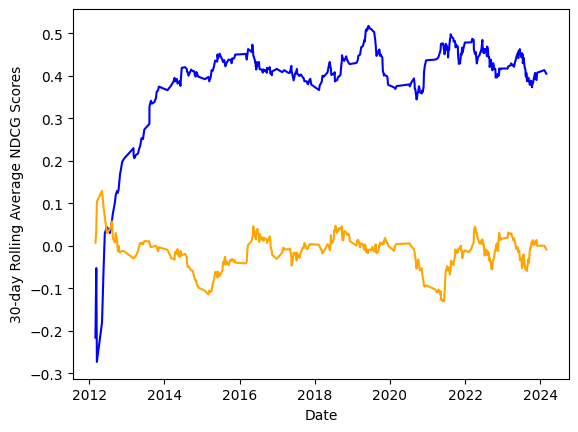

In [53]:
ax = sns.lineplot(
    data=metric_df[
        (metric_df["organization"] == "ifbb")
        & (metric_df["division"] == "bikini")
        & (metric_df["class"] == "open")
    ],
    x="date",
    y="30dayrollavg_kt_corr",
    color="blue"
)
ax2 = sns.lineplot(
    data=metric_df[
        (metric_df["organization"] == "ifbb")
        & (metric_df["division"] == "bikini")
        & (metric_df["class"] == "open")
    ],
    x="date",
    y="30dayrollavg_kt_corr_random",
    color="orange"
)
plt.xlabel("Date")
plt.ylabel("30-day Rolling Average NDCG Scores")
# plt.axhline(0.05, color='green')
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [32]:
df['contest_date'] = pd.to_datetime(df['contest_date'], format='%Y-%m-%d')

In [41]:
df_winners = df[df['placing'] == 1]
df_gb = df_winners.groupby(["organization",
                            "division",
                            "class",
                            "contest_date"])["elo_rating"].mean()
df_elo_winners = pd.DataFrame(df_gb).reset_index()
df_elo_winners = df_elo_winners.sort_values(by = ["contest_date", "organization", "division", "class"])
df_elo_winners["30dayrollavg_win_elo_rating"] = df_elo_winners.groupby(["organization", 'division', 'class'])["elo_rating"].transform(lambda x: x.rolling(30, 30).mean())

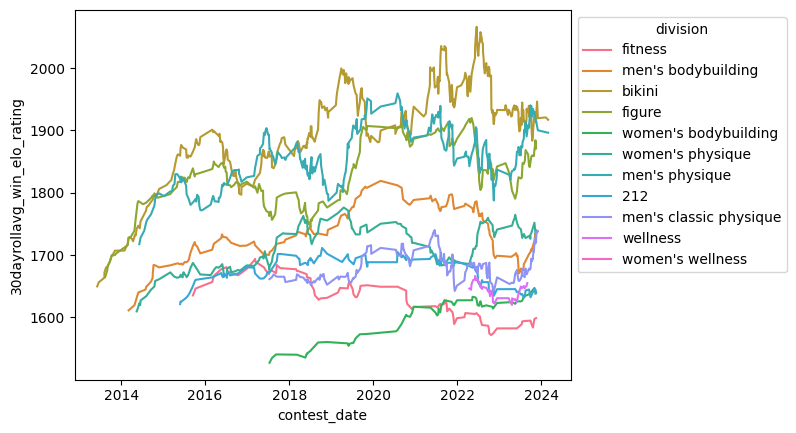

In [46]:
ax = sns.lineplot(
    data=df_elo_winners[
        (df_elo_winners["organization"] == "ifbb")
        & (df_elo_winners["class"] == "open")
    ],
    x="contest_date",
    y="30dayrollavg_win_elo_rating",
    hue="division"
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))